In [1]:
import os, sys
from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent.absolute()))

In [2]:
import matplotlib.pyplot as plt

im = plt.imread("cameraman.tif")[::8, ::8]
im.shape

(64, 64)

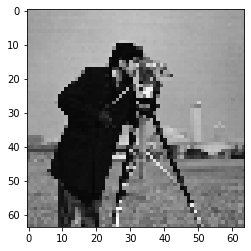

In [3]:
plt.imshow(im, cmap='gray')

In [4]:
from gspy.create import make_grid
import numpy as np
import copy
import tqdm

def l2norm(x):
    return np.sqrt(np.sum((np.abs(x))**2))

def are(x, xr):
    return l2norm(x - xr) / l2norm(x)

def reconstruct_from_p(x, U, Uinv, p):
    x_ = x.reshape((len(U), 1))
    xx_ = Uinv @ x_
    idx = np.argsort(np.abs(xx_).ravel())[::-1]
    out = U[:, idx[:p]] @ xx_[idx[:p]]
    return out

def are_vs_p_curve(A, verbose=True):
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    if verbose:
        print("Decomposing L.")
    _, U = np.linalg.eig(L)
    if verbose:
        print("Inverting U.")
    Uinv = np.linalg.inv(U)
    p_values = np.arange(10, len(U))[::50]
    are_values = list()

    for p in (tqdm.tqdm(p_values) if verbose else p_values):
        xr = reconstruct_from_p(im.ravel(), U, Uinv, p=p)
        N, M = im.shape
        imr = xr.reshape((N, M))
        are_values.append(are(im.ravel(), imr.ravel()))
    idx = np.array(are_values) < 0.1
    smallest_p = p_values[idx][0]
    return p_values, are_values, smallest_p, idx

# Approach 1: grid graph with unit weights

Decomposing L.
Inverting U.


100%|██████████| 82/82 [00:09<00:00,  8.56it/s]

Compression: 0.130859375


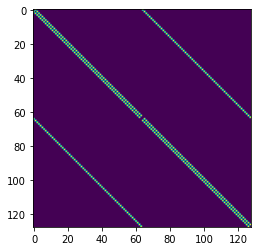

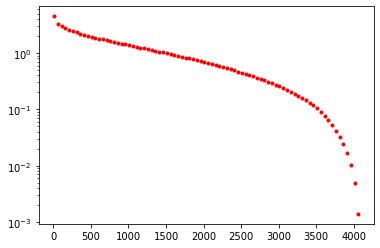

In [5]:
N, M = im.shape
A, coords = make_grid(N, M)
plt.figure()
plt.imshow(A[:128, :128])

p_values1, are_values1, smallest_p1, idx1 = are_vs_p_curve(A)
print("Compression:", (N*M - smallest_p1)/(N*M))

plt.figure()
plt.plot(p_values1, are_values1, 'r.', label="Abordagem 1")
plt.yscale("log")
plt.show()

In [6]:
# xr = reconstruct_from_p(im.ravel(), U, Uinv, p=4000)
# N, M = im.shape
# imr = xr.reshape((N, M))
# plt.imshow(np.abs(imr))

In [ ]:
# def reconstruct_from_p(x, U, Uinv, p):
#     x_ = x.reshape((len(U), 1))
#     xx_ = Uinv @ x_
#     idx = np.argsort(np.abs(xx_).ravel())[::-1]
#     out = U[:, idx[:p]] @ xx_[idx[:p]]
#     return out

# for p in [5, 800, 1500, 2500, 3200]:
#     xr = reconstruct_from_p(im.ravel(), U, Uinv, p=p)
#     N, M = im.shape
#     imr = xr.reshape((N, M))
#     print(p, are(im.ravel(), imr.ravel()))
#     plt.figure()
#     plt.imshow(np.abs(imr))

# Approach 2: updating weights to minimize the graph signal variance

Iteration limit reached    (Exit mode 9)
            Current function value: 3902.1100674202185
            Iterations: 5
            Function evaluations: 644
            Gradient evaluations: 5
Successfull? False
Decomposing L.
Inverting U.


100%|██████████| 82/82 [00:07<00:00, 10.69it/s]


Compression: 0.36279296875


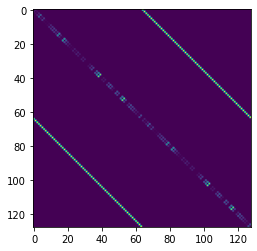

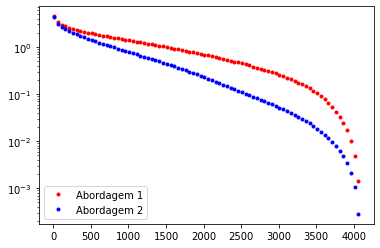

In [22]:
from scipy.optimize import minimize

def signal_variation(weights):
    N, M = im.shape
    A, _ = make_grid(N, M, weights_r=weights[:(N-1)], weights_c=weights[(N-1):])
    x = im.ravel().reshape((N*M, 1))
    return np.linalg.norm(A @ x - x)

N, M = im.shape
rnd = np.random.RandomState(seed=2021)
weights0 = 0.5 + 0.3 * rnd.randn(N-1 + M-1)
weights0[weights0 < 0] = 0

res = minimize(
    signal_variation, x0=weights0, method='SLSQP',
    bounds=[(0, None) for i in range(len(weights0))],
    options=dict(disp=True, maxiter=5))

print("Successfull?", res.success)
weights = res.x

N, M = im.shape
A2, _ = make_grid(N, M, weights_r=weights[:(N-1)], weights_c=weights[(N-1):])
plt.figure()
plt.imshow(A2[:128, :128])

p_values2, are_values2, smallest_p2, idx2 = are_vs_p_curve(A2)
print("Compression:", (N*M - smallest_p2)/(N*M))

plt.figure()
plt.plot(p_values1, are_values1, 'r.', label="Abordagem 1")
plt.plot(p_values2, are_values2, 'b.', label="Abordagem 2")
plt.yscale("log")
plt.legend(loc="lower left")
plt.show()

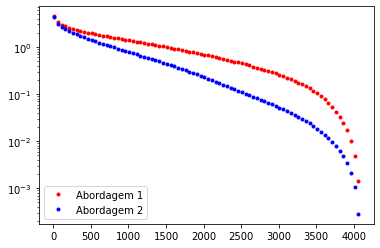

In [27]:
plt.figure()
plt.plot(p_values1, are_values1, 'r.', label="Abordagem 1")
plt.plot(p_values2, are_values2, 'b.', label="Abordagem 2")
plt.yscale("log")
plt.legend(loc="lower left")
plt.savefig("are_vs_p_v2.pdf", dpi=300)

In [26]:
N, M = im.shape
weights_naive = [1] * (N-1 + M-1)
print("Total variation with unit weights:", signal_variation(weights_naive))

Total variation with unit weights: 24754.72062052004
